In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import gensim
import torch.nn as nn
import torch.nn.functional as F
from gensim.corpora import Dictionary
from tqdm import tqdm
import re
import copy
import scipy.stats
import nltk
import pickle
import math

stopwords = nltk.corpus.stopwords.words('english')
class WAE(nn.Module):
    def __init__(self, encode_dims=[2000, 1024, 512, 20], decode_dims=[20, 1024, 2000], dropout=0.0, nonlin='relu'):
        super(WAE, self).__init__()
        self.encoder = nn.ModuleDict({
            f'enc_{i}': nn.Linear(encode_dims[i], encode_dims[i+1])
            for i in range(len(encode_dims)-1)
        })

        self.decoder = nn.ModuleDict({
            f'dec_{i}': nn.Linear(decode_dims[i], decode_dims[i+1])
            for i in range(len(decode_dims)-1)
        })
        self.latent_dim = encode_dims[-1]
        self.dropout = nn.Dropout(p=dropout)
        self.nonlin = {'relu': F.relu, 'sigmoid': torch.sigmoid}[nonlin]
        self.z_dim = encode_dims[-1]
        
    def encode(self, x):
        hid = x
        for i, (_,layer) in enumerate(self.encoder.items()):
            hid = self.dropout(layer(hid))
            if i < len(self.encoder)-1:
                hid = self.nonlin(hid)
        return hid
    
class VAE(nn.Module):
    def __init__(self, encode_dims=[2000,1024,512,20],decode_dims=[20,1024,2000],dropout=0.0):

        super(VAE, self).__init__()
        self.encoder = nn.ModuleDict({
            f'enc_{i}':nn.Linear(encode_dims[i],encode_dims[i+1]) 
            for i in range(len(encode_dims)-2)
        })
        self.fc_mu = nn.Linear(encode_dims[-2],encode_dims[-1])
        self.fc_logvar = nn.Linear(encode_dims[-2],encode_dims[-1])

        self.decoder = nn.ModuleDict({
            f'dec_{i}':nn.Linear(decode_dims[i],decode_dims[i+1])
            for i in range(len(decode_dims)-1)
        })
        self.latent_dim = encode_dims[-1]
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(encode_dims[-1],encode_dims[-1])
        
    def encode(self, x):
        hid = x
        for i,layer in self.encoder.items():
            hid = F.relu(self.dropout(layer(hid)))
        mu, log_var = self.fc_mu(hid), self.fc_logvar(hid)
        return mu, log_var
        
class WTM:
    def __init__(self, bow_dim=10000, n_topic=20, device=None, dist='gmm_std', taskname=None, dropout=0.0):
        self.bow_dim = bow_dim
        self.n_topic = n_topic
        self.wae = WAE(encode_dims=[bow_dim, 1024, 512, n_topic], decode_dims=[n_topic, 512, bow_dim], dropout=dropout, nonlin='relu')
        self.device = device
        self.id2token = None
        self.dist = dist
        self.taskname = taskname
        if device != None:
            self.wae = self.wae.to(device)
            
    def inference(self, doc_bow):
    # doc_bow: torch.tensor [vocab_size]; optional: np.array [vocab_size]
        with torch.no_grad():
            theta = F.softmax(self.wae.encode(doc_bow),dim=1)
            return theta.detach().cpu().numpy().reshape(75,)
        

class GSM:
    def __init__(self,bow_dim=10000,n_topic=20,taskname=None,device=None):
        self.bow_dim = bow_dim
        self.n_topic = n_topic
        #TBD_fc1
        self.vae = VAE(encode_dims=[bow_dim,1024,512,n_topic],decode_dims=[n_topic,512,bow_dim],dropout=0.0)
        self.device = device
        self.id2token = None
        self.taskname = taskname
        if device!=None:
            self.vae = self.vae.to(device)

    def inference(self,doc_bow):
        # doc_bow: torch.tensor [vocab_size]; optional: np.array [vocab_size]
        with torch.no_grad():
            mu,log_var =self.vae.encode(doc_bow)
            mu = self.vae.fc1(mu)
            theta = F.softmax(mu,dim=1)
            return theta.detach().cpu().squeeze(0).numpy()   
        
        
class LDA:
    def __init__(self):
        self.lda_model = gensim.models.ldamodel.LdaModel.load('D:\毕设\ML算法实现\主题模型攻击\\nips_model\LDA_nips.ckpt')
    
    def inference(self,doc):
        doc_bow = self.lda_model.id2word.doc2bow(doc)      #文档转换成bow
        doc_lda = self.lda_model[doc_bow] 
        doc_tp = np.zeros(75)+0.001
        for i in doc_lda:
            doc_tp[i[0]] = i[1]
        return doc_tp



D:\Anaconda\next_anaconda\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
D:\Anaconda\next_anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy

In [2]:
class EVAE(VAE):
    def __init__(self, encode_dims=[2000,1024,512,20],decode_dims=[20,1024,2000],dropout=0.0,emb_dim=300):
        super(EVAE,self).__init__(encode_dims=encode_dims,decode_dims=decode_dims,dropout=dropout)
        self.emb_dim = emb_dim
        self.vocab_size = encode_dims[0]
        self.n_topic = encode_dims[-1]
        self.rho = nn.Linear(emb_dim,self.vocab_size)
        self.alpha = nn.Linear(emb_dim,self.n_topic)
        self.decoder = None

    def decode(self,z):
        wght_dec = self.alpha(self.rho.weight) #[K,V]
        beta = F.softmax(wght_dec,dim=0).transpose(1,0)
        res = torch.mm(z,beta)
        logits = torch.log(res+1e-6)
        return logits


class ETM:
    def __init__(self,bow_dim=10000,n_topic=20,taskname=None,device=None,emb_dim=300):
        self.bow_dim = bow_dim
        self.n_topic = n_topic
        self.emb_dim = emb_dim
        #TBD_fc1
        self.vae = EVAE(encode_dims=[bow_dim,1024,512,n_topic],decode_dims=[n_topic,512,bow_dim],dropout=0.0,emb_dim=emb_dim)
        self.device = device
        self.id2token = None
        self.taskname = taskname
        if device!=None:
            self.vae = self.vae.to(device)
            
    def inference(self,doc_bow):
    # doc_bow: torch.tensor [vocab_size]; optional: np.array [vocab_size]
        if isinstance(doc_bow,np.ndarray):
            doc_bow = torch.from_numpy(doc_bow)
        doc_bow = doc_bow.reshape(-1,self.bow_dim).to(self.device)
        with torch.no_grad():
            mu,log_var = self.vae.encode(doc_bow)
            mu = self.vae.fc1(mu) 
            theta = F.softmax(mu,dim=1)
            return theta.detach().cpu().squeeze(0).numpy()

In [8]:
class Biterm():
    wi = 0
    wj = 0
    z = 0

    def __init__(self,w1=None,w2=None,s=None):
        if w1 != None and w2 != None:
            self.wi = min(w1,w2)
            self.wj = max(w1,w2)
        elif w1 == None and w2 == None and s != None:
            w = s.split(' ')
            self.wi = w[0]
            self.wj = w[1]
            self.z = w[2]

    def get_wi(self):
        return self.wi

    def get_wj(self):
        return self.wj

    def get_z(self):
        return self.z

    def set_z(self,k):
        self.z = k

    def reset_z(self):
        self.z = -1

    def str(self):
        _str = ""
        _str += str(self.wi) + '\t' + str(self.wj) + '\t\t' + str(self.z)
        return _str
class Doc():
    '''
    @description: 处理文本的类
    @param {type} 
    @return: 
    '''
    ws = []

    def __init__(self,s,voc):
        self.ws = []
        self.dict = dict()
        with open(voc, 'r') as f:
            voclist = f.read().splitlines()
        for i in range(len(voclist)):
            self.dict[voclist[i]] = i
        self.read_doc(s)

    def read_doc(self,s):
        if s != '\n':
            for w in s.split(' '):
                if w not in self.dict:
                    continue
                self.ws.append(int(self.dict[w]))
                
    def show(self):
        print('ceshi:', self.ws)
        print('字典:', self.dict)

    def size(self):
        return len(self.ws)

    def get_w(self,i):
        assert(i<len(self.ws))
        return self.ws[i]

    ''' 
      Extract biterm from a document
        'win': window size for biterm extraction
        'bs': the output biterms
    '''
    def gen_biterms(self,bs,win=15):
        if(len(self.ws)<2):
            return
        for i in range(len(self.ws)-1):
            for j in range(i+1,min(i+win,len(self.ws))):
                bs.append(Biterm(self.ws[i],self.ws[j]))
                
class BTModel:
    def __init__(self, model_dir, voca_path):
        self.zw_pt = list()
        with open(model_dir+'k75.pw_z') as f:
            for line in f.readlines():
                self.zw_pt.append([float(p) for p in line.split()])
        self.pz = [float(p) for p in open(model_dir+'k75.pz').readline().split()]
        self.voca_path = voca_path
        
    def inference(self, test_path):
        def softmax(x):
            exp_x = np.exp(x)
            sum_exp_x = np.sum(exp_x)
            y = exp_x/sum_exp_x
            return y
        
        def load_docs(docs_pt):
            bs = []
#             print("load docs: " + docs_pt)
#             rf = open(docs_pt)
#             if not rf:
#                 print("file not found: " + docs_pt)
#             for line in rf.readlines():
            line = docs_pt
            d = Doc(line, self.voca_path)
#             d.show()
#             print('d in load_docs:', d)
            biterms = []
            d.gen_biterms(biterms)
            for b in biterms:
                bs.append(b)
            # print(len(bs))
            return bs
        bs = load_docs(test_path)
        K = len(self.pz)
        #print('KKKK', K)
        zw_pt = self.zw_pt
        pz_d = [0.0]*K
        if len(bs) == 1:
            for k in range(K):
                pz_d[k] = math.log(self.pz[k]) + math.log(zw_pt[k][bs[0].get_wi()])
            pz_d = softmax(pz_d)
        else:
            for bs_i in bs:
                w1 = bs_i.get_wi()
                w2 = bs_i.get_wj()
                pz_b = [0.0]*K
                for k in range(K):
    #                 print(pz[k])
                    pz_b[k] = math.log(self.pz[k]) + math.log(zw_pt[k][w1]) + math.log(zw_pt[k][w2])
    #             print(pz_b)
                pz_b = softmax(pz_b)
                for kk in range(K):
                    pz_d[kk] += pz_b[kk]
            pz_d = softmax(pz_d)
        return pz_d

In [3]:
class CTModel:
    def __init__(self, path):
        # path : 模型的存储路径 model-50
        self.model = pickle.load(open(path, "rb"))
    def inference(self, text):
        # text: str
        log_likelihood, lambda_values, nu_square_values = self.model.inference([text])
        def softmax(x):
            exp_x = np.exp(x)
            sum_exp_x = np.sum(exp_x)
            y = exp_x/sum_exp_x
            return y
        return softmax(lambda_values)[0]

In [4]:
import tomotopy as tp # 载入库

class PTModel:
    def __init__(self, path):
        # path : 模型的存储路径
        self.model = tp.PTModel.load(path)
    def inference(self, text):
        # text: 以空格间隔开的文本
        #txt = text.split(' ')
        doc_inst = self.model.make_doc(text)
        topic_dist, ll = self.model.infer(doc_inst)
        return topic_dist
class DMRModel:
    def __init__(self, path):
        # path : 模型的存储路径
        self.model = tp.DMRModel.load(path)
    def inference(self, text):
        # text: 以空格间隔开的文本
        #txt = text.split(' ')
        doc_inst = self.model.make_doc(text)
        topic_dist, ll = self.model.infer(doc_inst)
        return topic_dist

In [5]:
import pandas as pd
we = pd.read_csv("D:\毕设\ML算法实现\主题模型攻击\pre_processing.csv")#相似词
we['similar_words'] = we['similar_words'].map(lambda x: eval(x))
def evals(x):
    if x == '<class \'list\'>':
        return []
    else:
        return eval(x)
we['similar_mixed'] = we['similar_mixed'].map(lambda x: evals(x))

# 索引字典
word2id = {}
count = 0
for i in we['word']:
    word2id[i] = count 
    count +=1

In [6]:
def to_bow(data, min_length):
    """Convert index lists to bag of words representation of documents."""
    vect = [np.bincount(x[x != np.array(None)].astype('int'), minlength=min_length)
            for x in data if np.sum(x[x != np.array(None)]) != 0]
    return np.array(vect)

def Tokenizer(sent,stopwords=None):
        # Tokenizer for English. 
        pat = re.compile(r'[0-9!"#$%&\'()*+,-./:;<=>?@—，。：★、￥…【】（）《》？“”‘’！\[\\\]^_`{|}~\u3000]+')
        tokens = [re.sub(pat,r'',t).strip() for t in sent.split(' ')]
        tokens = [t for t in tokens if t!='' and len(t)>1]
        tokens = [t.lower() for t in tokens]    
        if stopwords is not None:
            tokens = [t for t in tokens if not (t in stopwords)]                                               
        return tokens

def word_embedding(dictionary,vim_txt,stopwords=None):
    '''
    #input 字典，文本txt
    #output 计数向量tensor 单词索引list
    '''
    with open(vim_txt,'r',encoding='utf-8') as f:
        txt = f.read()
    ori_token = Tokenizer(txt,stopwords)
    ori_bow = torch.zeros(1,len(dictionary))
    ori_index = []
    new_token = []
    for token in ori_token:
            try:
                ori_idx = dictionary.token2id[token.lower()]
                ori_index.append(ori_idx)
                ori_bow[0][ori_idx] += 1
                new_token.append(token)
            except:
                continue
    return ori_bow,ori_index,new_token,len(ori_token)

def topk_import_words(ori_index,ori_bow,ori_token,model,dictionary,ori_result,model_name,i=0):
    '''
    当model_name = LDA时，ori_index = token，ori_bow
    #关键词排序
    #input
    #topk：前k个词
    #ori_index:单词索引
    #ori_bow:单词向量
    #model：攻击模型
    #ori_result:原始主题分布
    #output
    #topk单词字典（word：KL value）
    #topk单词索引
    '''
    diff_re ={} # 删除词后的主题分布
    if model_name == 'LDA' or model_name == "PT" or model_name == "DMR":
        for word in set(ori_token):
            temp = copy.deepcopy(ori_token)
            temp.remove(word)
            LDA_tmp_result = model.inference(temp)
            try:
                diff_re[word] = scipy.stats.entropy(LDA_tmp_result,ori_result)
            except:
                print(len(LDA_tmp_result),len(ori_result))
                print(temp)
                 
    elif model_name == 'CTM' or model_name == 'BTM':
        for word in set(ori_token):
            temp = copy.deepcopy(ori_token)
            temp.remove(word)
            tmp = " ".join(temp)
            LDA_tmp_result = model.inference(tmp)
            diff_re[word] = scipy.stats.entropy(LDA_tmp_result,ori_result)
            #print(LDA_tmp_result)
            
    else:
        for idx in ori_index:
            tmp_bow = ori_bow.clone()
            tmp_bow[i][idx] = 0
            tmp_result = model.inference(tmp_bow)
            diff_re[dictionary[idx]] = scipy.stats.entropy(tmp_result,ori_result)

    #return sorted(diff_re.items(),key = lambda item:item[1],reverse = True)
    
    return diff_re

def softmax(kl):
    s = sum(kl.values())
    for i in kl.keys():
        #a = kl[i]
        #print(a)
        #tmp = a/s
        kl[i]  = kl[i]/s
    #return sorted(kl.items(),key = lambda item:item[1],reverse = True)
    return kl

def similar_word(t_word):
    #返回该词的近义词列表
    return we['similar_words'][word2id[t_word]:word2id[t_word]+1][word2id[t_word]]

def rep_sim_word(ori_bow,ori_token,sim_word,t_word,dictionary,model_name,model,i=0):
    '''
    返回kl散度
    '''
    #修改词向量
    token = copy.deepcopy(ori_token)
    bow = ori_bow.clone()
    if model_name == "LDA" or model_name == "PT" or model_name == "DMR":
        ori = model.inference(token)
        token[token.index(t_word)] = sim_word
        tmp_re = model.inference(token)
        return scipy.stats.entropy(tmp_re,ori)
    
    elif model_name == 'CTM' or model_name == 'BTM':
        tmp = " ".join(token)
        ori = model.inference(tmp)
        token[token.index(t_word)] = sim_word
        tmp = " ".join(token)
        tmp_re = model.inference(tmp)
        return scipy.stats.entropy(tmp_re,ori)
        
    else:
        ori = model.inference(bow)
        tmp = bow[i][dictionary.token2id[t_word]]
        bow[i][dictionary.token2id[sim_word]] += tmp
        bow[i][dictionary.token2id[t_word]] = 0
        tmp_re = model.inference(bow)
        return scipy.stats.entropy(tmp_re,ori)

def sim_word_kl(sim_word_list,ori_bow,ori_token,threshold,weight,i=0):
    sim_kl = {}
    for j in range(len(sim_word_list)):
        s_ = 0 #同义词的kl散度变化
        sim_word = sim_word_list[j][0]
        try:
            a = dictionary.token2id[sim_word]
        except:
            #print(f'{sim_word} 该同义词不在字典中')
            continue
        
        for _ in range(model_num):
            tmp =  rep_sim_word(ori_bow,ori_token,sim_word,word,dictionary,model_name[_],model_set[_],i=0)
            s_ += tmp/threshold[_] * weight[_]
        sim_kl[sim_word] = s_
    return sorted(sim_kl.items(),key = lambda item:item[1],reverse = True)

def generate_vim(ori_txt,vim_txt,pair):
    with open(ori_txt,'r') as f:
        ori = f.read()
    ori = Tokenizer(ori)
    for i in pair.keys():
        while i in ori:
            ori[ori.index(i)] = pair[i]
    txt = " ".join(ori)
    with open(vim_txt,'w') as f:
        f.write(txt)
    return 0

In [7]:
#dictionary = Dictionary.load('D:\毕设\ML算法实现\主题模型攻击\WTM_dict.dict')
#WTM_path = 'D:\毕设\ML算法实现\主题模型攻击\WTM.pickle'
#WTM_parameters = torch.load(WTM_path,map_location=torch.device('cpu'))
#WTM_model = WTM(bow_dim = 37327,n_topic= 75)
#WTM_model.wae.load_state_dict(WTM_parameters)
#GSM_path = 'D:\毕设\ML算法实现\主题模型攻击\\38440_GSM.pickle'
#GSM_parameters = torch.load(GSM_path,map_location=torch.device('cpu'))
#GSM_model = GSM(bow_dim = 37327,n_topic= 75)# 参数设置
#GSM_model.vae.load_state_dict(GSM_parameters)
#LDA_model = LDA()

In [8]:
dictionary = Dictionary.load('D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_16157.dict')
WTM_D_path = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\WTM_D.pickle'
WTM_parameters = torch.load(WTM_D_path,map_location=torch.device('cpu'))
WTM_D_model = WTM(bow_dim = 16157,n_topic= 75)
WTM_D_model.wae.load_state_dict(WTM_parameters)

WTM_G_path = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\WTM_G.pickle'
WTM_parameters = torch.load(WTM_G_path,map_location=torch.device('cpu'))
WTM_G_model = WTM(bow_dim = 16157,n_topic= 75)
WTM_G_model.wae.load_state_dict(WTM_parameters)

GSM_path = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\GSM_nips.pickle'
GSM_parameters = torch.load(GSM_path,map_location=torch.device('cpu'))
GSM_model = GSM(bow_dim = 16157,n_topic= 75)# 参数设置
GSM_model.vae.load_state_dict(GSM_parameters)
LDA_model = LDA()
ETM_path = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\ETM_nips.pickle'
ETM_parameters = torch.load(ETM_path,map_location=torch.device('cpu'))
ETM_model = ETM(bow_dim = 16157,n_topic= 75)# 参数设置
ETM_model.vae.load_state_dict(ETM_parameters)

DMR_model = DMRModel('NIPS_DMRModel.bin')
PT_model = PTModel('NIPS_PTModel.bin')

CTM_model = CTModel('D:\毕设\ML算法实现\主题模型攻击\\nips_model\ctm\\nips_model-50')

In [68]:
lda = []
rate = []
topk = 0.05
for i in range(100):
    if i == 79:
        continue
    print("处理第{}个文本".format(i))
    vim_txt = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_' + str(i) + '.txt'
    new_vim_txt = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_UAE\\'+ "G_WD_UAE_" + str(topk)+ "_" + str(i) + '.txt'
    model_name = ["GSM","ETM"]
    model_set = [GSM_model,ETM_model]
    model_num = len(model_name)
    r_set = []
    ori_bow,ori_index,ori_token,length = word_embedding(dictionary,vim_txt)
    for j in range(model_num):
        if model_name[j] == "LDA" or model_name[j] == "PT" or model_name[j] == "DMR":
            r = model_set[j].inference(ori_token)
            r_set.append(r)
        elif model_name[j] == 'CTM' or model_name[j] == 'BTM' :
            tmp = " ".join(ori_token)
            r = model_set[j].inference(tmp)
            r_set.append(r)
        else:
            r = model_set[j].inference(ori_bow)
            r_set.append(r)
            
            
    #ori_gsm_re = LDA_model.inference(ori_token)

    kl_set = []
    for j in range(model_num):
        a = topk_import_words(ori_index,ori_bow,ori_token,model_set[j],dictionary,r_set[j],model_name[j])
        kl_set.append(a)

    soft_kl_set = []
    for j in range(model_num):
        a = softmax(kl_set[j])
        soft_kl_set.append(a)
    new_kl = {}
    for j in soft_kl_set[0].keys():
        s_kl = 0
        for jj in range(model_num):
            s_kl += soft_kl_set[jj][j]
        new_kl[j] = s_kl


    ###############################################################
    threshold =np.array([1.5,2])
    #hyp = np.array([1,38,1])
    pair = {}
    process = []
    weight = np.ones(model_num)
    weight_set = []
    arrive = np.zeros(model_num)
    new_kl =  sorted(new_kl.items(),key = lambda item:item[1],reverse = True)
    count = 0
    LDA_re = 0
    for j in new_kl:
        word = j[0]
        try:
            sim_word_list = similar_word(word)
        except:
            #print(f'{word} 该词中无近义词')
            continue

        sim_kl = sim_word_kl(sim_word_list,ori_bow,ori_token,threshold,weight)
        #print(sim_kl)
        if len(sim_kl) == 0:
            continue
        else:
            best_sim_word = sim_kl[0][0]
            pair[word] = best_sim_word

        #对oir_bow和ori_token迭代
        tmp = ori_bow[0][dictionary.token2id[word]]
        ori_bow[0][dictionary.token2id[best_sim_word]] += tmp
        ori_bow[0][dictionary.token2id[word]] = 0
        ori_token[ori_token.index(word)] = best_sim_word


        
        tmp_r_set = []
        tmp_kl_set = []
    #ori_bow,ori_index,ori_token = word_embedding(dictionary,'D:\毕设\ML算法实现\主题模型攻击\ori_0.txt')
    
        for j in range(model_num):
            if model_name[j] == "LDA" or model_name[j] == "PT" or model_name[j] == "DMR":
                r = model_set[j].inference(ori_token)
                tmp_r_set.append(r)
            elif model_name[j] == 'CTM' or model_name[j] == 'BTM' :
                tmp = " ".join(ori_token)
                r = model_set[j].inference(tmp)
                tmp_r_set.append(r)
            else:
                r = model_set[j].inference(ori_bow)
                tmp_r_set.append(r)

        for j in  range(model_num):
            t = scipy.stats.entropy(tmp_r_set[j],r_set[j])
            tmp_kl_set.append(t)

        
        process.append(tmp_kl_set) #过程中kl变化
        tmp_kl_set = np.array(tmp_kl_set)
        weight = (1 - np.minimum((tmp_kl_set/threshold),1)) 
        weight_set.append(weight)

        if ((tmp_kl_set>threshold).all() == True):
            break
        if len(pair) > length * 0.1:
            break
    rate.append(len(pair)/length)        
    #att = LDA_model.inference(ori_token)
    #lda.append(scipy.stats.entropy(ori_gsm_re,att))
    #generate_vim(vim_txt,new_vim_txt,pair)

处理第0个文本
处理第1个文本
处理第2个文本
处理第3个文本
处理第4个文本
处理第5个文本
处理第6个文本
处理第7个文本
处理第8个文本
处理第9个文本
处理第10个文本
处理第11个文本
处理第12个文本
处理第13个文本
处理第14个文本
处理第15个文本
处理第16个文本
处理第17个文本
处理第18个文本
处理第19个文本
处理第20个文本
处理第21个文本
处理第22个文本
处理第23个文本
处理第24个文本
处理第25个文本
处理第26个文本
处理第27个文本
处理第28个文本
处理第29个文本
处理第30个文本
处理第31个文本
处理第32个文本
处理第33个文本
处理第34个文本
处理第35个文本
处理第36个文本
处理第37个文本
处理第38个文本
处理第39个文本
处理第40个文本
处理第41个文本
处理第42个文本
处理第43个文本
处理第44个文本
处理第45个文本
处理第46个文本
处理第47个文本
处理第48个文本
处理第49个文本
处理第50个文本
处理第51个文本
处理第52个文本
处理第53个文本
处理第54个文本
处理第55个文本
处理第56个文本
处理第57个文本
处理第58个文本
处理第59个文本
处理第60个文本
处理第61个文本
处理第62个文本
处理第63个文本
处理第64个文本
处理第65个文本
处理第66个文本
处理第67个文本
处理第68个文本
处理第69个文本
处理第70个文本
处理第71个文本
处理第72个文本
处理第73个文本
处理第74个文本
处理第75个文本
处理第76个文本
处理第77个文本
处理第78个文本
处理第80个文本
处理第81个文本
处理第82个文本
处理第83个文本
处理第84个文本
处理第85个文本
处理第86个文本
处理第87个文本
处理第88个文本
处理第89个文本
处理第90个文本
处理第91个文本
处理第92个文本
处理第93个文本
处理第94个文本
处理第95个文本
处理第96个文本
处理第97个文本
处理第98个文本
处理第99个文本


In [69]:
sum(rate)/len(rate)

0.04270841708242968

In [10]:
def eval(ori_txt,vim_txt,model,model_name):
    # model:[LDA_model,GSM_model]模型列表
    ori_bow,ori_index,ori_token,o_length = word_embedding(dictionary,ori_txt)
    vim_bow,vim_index,vim_token,v_length = word_embedding(dictionary,vim_txt)
    ori_r_set = []
    vim_r_set = []
    for i in range(len(model)):
        if model_name[i] == "LDA" or model_name[i] == "PT" or model_name[i] == "DMR":
            r = model[i].inference(ori_token)
            ori_r_set.append(r)
            r = model[i].inference(vim_token)
            vim_r_set.append(r)
        elif model_name[i] == 'CTM' or model_name[i] == 'BTM':
            tmp = " ".join(ori_token)
            r = model[i].inference(tmp)
            ori_r_set.append(r)
            temp = " ".join(vim_token)
            r = model[i].inference(temp)
            vim_r_set.append(r)
        else:
            r = model[i].inference(ori_bow)
            ori_r_set.append(r)
            r = model[i].inference(vim_bow)
            vim_r_set.append(r)
            
    kl =[]
    for i in range(len(model)):
        kl.append(scipy.stats.entropy(ori_r_set[i],vim_r_set[i]))
    return kl

In [17]:
eval_model_name = ["LDA","WTM_G","GSM","WTM_D","ETM","PT","DMR","CTM"]
#eval_model_name = ["CTM","BTM"]
eval_model = [LDA_model,WTM_G_model,GSM_model,WTM_D_model,ETM_model,PT_model,DMR_model,CTM_model]
#eval_model = [CTM_model,BTM_model]
topk = 0.05
kl = []
for i in range(50):
    ori_txt = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_' + str(i) + '.txt'
    vim_txt ='D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_UAE\\'+ "G_E_UAE_" + str(topk)+ "_" + str(i) + '.txt'
    #vim_txt =eval_model_name[4] + "trans_" + str(topk)+ "_" + str(i) + '.txt'
    #vim_txt =eval_model_name[8] + "trans_" + str(topk)+ "_" + str(i) + '.txt'
    tmp = eval(ori_txt,vim_txt,eval_model,eval_model_name)
    kl.append(tmp)
kl = np.array(kl)
for i in range(len(eval_model_name)):
    print("{}:{}".format(eval_model_name[i],np.median(kl[:,i])))


LDA:1.069596929134411
WTM_G:1.4292077422142029
GSM:1.5641904473304749
WTM_D:1.9409059882164001
ETM:1.9801549911499023
PT:0.19248782098293304
DMR:1.057363212108612
CTM:0.39431057253777635


| nips 组合| 迁移性LDA,WTM_G,GSM,WTM_D,ETM,CTM,PT,DMR |平均迁移性 $\uparrow$ |方差 $\downarrow$ |  扰动率 $\downarrow$|综合得分$\uparrow$
|  ----  | ----  | ----  |---- | ---- | ----
| GSM-WTM_D  | 0.89,1.2,1.4,2.2,1.28,0.3,0.16,0.97  | 1.05| 0.36| 3.5%  |0.03
| GSM-WTM_D-ETM  | 1.1,1.62,1.53,2.5,2.02,0.36,0.15,1.2  | 1.31| 0.54|4.4%  |0.05
| WTM_D-ETM  | 0.8,1.04,0.81,1.75,1.61,0.29,0.11,0.98  | 0.92| 0.28|3.7%  |0.03
| GSM-ETM  | 1.06,1.42,1.56,1.94,1.98,0.39,0.19,1.05 | 1.19| 0.38|4.2% |0.05
| (based1)LDA-DMR | 0.56,0.42,0.26,0.33,0.27,0.12,0.04,0.84| 0.355|0.05 |10% |0
| (based1)LDA-WTM_G | 1.92,2.25,1.39,1.84,1.67,0.53,0.19,2.03| 1.47| 0.47| 11.2%|0.003
| (based1)GSM-DMR| 1.24,1.47,1.24,1.82,1.69,0.47,0.14,1.62| 1.21|0.31 | 11.2%|0.008

|  组合| 迁移性LDA,WTM_G,GSM,WTM_D,ETM,CTM,PT,DMR |平均迁移性 $\uparrow$ |方差 $\downarrow$ |  扰动率 $\downarrow$|综合得分$\uparrow$
|  ----  | ----  | ----  |---- | ---- | ----
| GSM-ETM  | 0.55,0.27,0.38,0.27,0.78,0.11,0.21,0.64  | 0.4| 0.047| 7%  |0.041
| WTM_G-ETM  | 0.55,0.42,0.17,0.25,0.48,0.11,0.18,0.49  | 0.33| 0.025|6.4%  |0.039
| WTM_G-ETM-GSM  | 0.65,0.47,0.32,0.31,0.63,0.14,0.21,0.72  | 0.43| 0.042|8.2%  |0.029
| WTM_G-ETM-GSM-WTM_D  | 0.62,0.45,0.26,0.42,0.59,0.14,0.21,0.67 | 0.42| 0.035|8.7% |0.016
| (based1)LDA-DMR | 0.45,0.02,0.005,0.02,0.002,0.01,0.11,0.45| 0.13|0.034 |5.4% |0.025
| (based1)LDA-WTM_G | 0.78,0.35,0.12,0.24,0.13,0.1,0.2,0.56| 0.31| 0.05| 8.4%|0.015
| (based1)GSM-DMR| 0.56,0.26,0.27,0.23,0.28,0.12,0.17,0.68| 0.32|0.033 | 7.6%|0.03


In [70]:
import numpy as np
def softmax(a):
    return np.exp(a)/sum(np.exp(a))

a  = np.array([[0.89,1.2,1.4,2.2,1.28,0.3,0.16,0.97],
               [1.1,1.62,1.53,2.5,2.02,0.36,0.15,1.2],
               [0.8,1.04,0.81,1.75,1.61,0.29,0.11,0.98],
               [1.06,1.42,1.56,1.94,1.98,0.39,0.19,1.05],
              [0.56,0.42,0.26,0.33,0.27,0.12,0.04,0.84],
               [1.92,2.25,1.39,1.84,1.67,0.53,0.19,2.03],
               [1.24,1.47,1.24,1.82,1.69,0.47,0.14,1.62]
              ])

'''
a  = np.array([[0.55,0.27,0.38,0.27,0.78,0.11,0.21,0.64],
               [0.55,0.42,0.17,0.25,0.48,0.11,0.18,0.49],
               [0.65,0.47,0.32,0.31,0.63,0.14,0.21,0.72],
               [0.62,0.45,0.26,0.42,0.59,0.14,0.21,0.67],
              [0.45,0.02,0.005,0.02,0.002,0.01,0.11,0.45],
               [0.78,0.35,0.12,0.24,0.13,0.1,0.2,0.56],
               [0.56,0.26,0.27,0.23,0.28,0.12,0.17,0.68]
              ])
'''
a_mean = softmax(np.mean(a,axis = 1))
a_var = softmax(np.var(a,axis  = 1))
rate = softmax(np.array([3.5,4.4,3.7,4.2,10,11.2,11.2]))
print(np.mean(a,axis = 1))
print(np.var(a,axis  = 1))
print(0.6*a_mean-0.3*a_var-0.1*rate)



[1.05    1.31    0.92375 1.19875 0.355   1.4775  1.21125]
[0.363375   0.546125   0.28279844 0.38153594 0.0566     0.47866875
 0.31656094]
[ 0.03634834  0.05127802  0.03025351  0.04828986 -0.00513467  0.03010972
  0.00885522]


|  组合| 迁移性 |平均迁移性 $\uparrow$ |方差 $\downarrow$ |  扰动率 |综合得分
|  ----  | ----  | ----  |---- | ---- | ----
| LDA  | 0.18,0.00,0.00  | 0.06| 0.007| 5%  |0.02
| GSM  | 0.16,1.37,0.07  | 0.53| 0.35|5%  |-0.42
| WTM  | 0.19,0.06,0.44  | 0.23| 0.024|5%  |0.076
| LDA-WTM  | 0.06,0.12,0.23 | 0.136| 0.004|4.9% |0.06
| LDA-GSM  | 0.06,0.53,0.15 | 0.246| 0.04|5.9%|0.05
| **WTM-GSM**  | **0.17,0.53,0.23** |0.31| 0.02| 5.5%|**0.13**
| LDA-WTM-GSM  | 0.06,0.53,0.23 |0.27|0.037| 8.4%|0.074

In [8]:
process

[]

In [9]:
process = np.array(process)
weight_set = np.array(weight_set)
count = 0
for i in process:
    count +=1
    if ((i>threshold).all() == True):
        print(count)
        break

In [10]:
from scipy.special import gamma
from scipy.special import factorial
N = len(process)
x = np.linspace(0, N,len(process))

plt.figure()
plt.plot(x, process[:,0], 'r-.*', lw=1, ms=5)
plt.plot(x, process[:,1], 'b-.*', lw=1, ms=5)
#plt.plot(x, process[:,2], 'g-.*', lw=1, ms=5)
plt.axhline(y=0.3,ls=":",c="r")#添加水平直线
plt.axhline(y=0.4,ls=":",c="b")#添加水平直线
#plt.axhline(y=0.3,ls=":",c="g")#添加水平直线
# plt.plot(x, y, color='r', linestyle='-.', marker='*', lw=1, ms=5) #和上面的语句表达的意思一样
#plt.title('阶乘和Gamma函数')
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<Figure size 432x288 with 0 Axes>

In [ ]:
N = len(process)
x = np.linspace(0, N,len(process))

plt.figure()
plt.plot(x, weight_set[:,0], 'r-.*', lw=1, ms=5)
plt.plot(x, weight_set[:,1], 'b-.*', lw=1, ms=5)
#plt.plot(x, weight_set[:,2], 'g-.*', lw=1, ms=5)

# plt.plot(x, y, color='r', linestyle='-.', marker='*', lw=1, ms=5) #和上面的语句表达的意思一样
#plt.title('阶乘和Gamma函数')
plt.show()

# 词云

In [12]:
import copy
def topk_import_words(ori_index,ori_bow,ori_token,model,dictionary,ori_result,model_name,i=0):
    '''
    当model_name = LDA时，ori_index = token，ori_bow
    #关键词排序
    #input
    #topk：前k个词
    #ori_index:单词索引
    #ori_bow:单词向量
    #model：攻击模型
    #ori_result:原始主题分布
    #output
    #topk单词字典（word：KL value）
    #topk单词索引
    '''
    diff_re ={} # 删除词后的主题分布
    if model_name == 'LDA' or model_name == "PT" or model_name == "DMR":
        for word in set(ori_token):
            temp = copy.deepcopy(ori_token)
            temp.remove(word)
            LDA_tmp_result = model.inference(temp)
            try:
                diff_re[word] = scipy.stats.entropy(LDA_tmp_result,ori_result)
            except:
                print(len(LDA_tmp_result),len(ori_result))
                print(temp)
                 
    elif model_name == 'CTM' or model_name == 'BTM':
        for word in set(ori_token):
            temp = copy.deepcopy(ori_token)
            temp.remove(word)
            tmp = " ".join(temp)
            LDA_tmp_result = model.inference(tmp)
            diff_re[word] = scipy.stats.entropy(LDA_tmp_result,ori_result)
            #print(LDA_tmp_result)
            
    else:
        for idx in ori_index:
            tmp_bow = ori_bow.clone()
            tmp_bow[i][idx] = 0
            tmp_result = model.inference(tmp_bow)
            diff_re[dictionary[idx]] = scipy.stats.entropy(tmp_result,ori_result)

    #return sorted(diff_re.items(),key = lambda item:item[1],reverse = True)
    
    return diff_re
vim_txt = 'D:\毕设\ML算法实现\主题模型攻击\py格式\WG_E_UAE_5.txt'
#new_vim_txt = 'D:\毕设\ML算法实现\主题模型攻击\py格式\WG_E_UAE_0.txt'
model_name = ["PT"]
model_set = [PT_model]
model_num = len(model_name)
r_set = []
zori_bow,zori_index,zori_token,length = word_embedding(dictionary,vim_txt)
#vim_bow,vim_index,vim_token,length = word_embedding(dictionary,new_vim_txt)
for j in range(model_num):
    if model_name[j] == "LDA" or model_name[j] == "PT" or model_name[j] == "DMR":
        r = model_set[j].inference(zori_token)
        r_set.append(r)
    elif model_name[j] == 'CTM' or model_name[j] == 'BTM' :
        tmp = " ".join(zori_token)
        r = model_set[j].inference(tmp)
        r_set.append(r)
    else:
        r = model_set[j].inference(zori_bow)
        r_set.append(r)



#ori_gsm_re = LDA_model.inference(ori_token)

vim_kl_set = []
for j in range(model_num):
    a = topk_import_words(zori_index,zori_bow,zori_token,model_set[j],dictionary,r_set[j],model_name[j])
    vim_kl_set.append(a)



[('ship', 0.22918364093847288), ('fire', 0.11046094748753471), ('injured', 0.04874952822335664), ('crew', 0.04108261500971671), ('navy', 0.03719235430953948), ('miles', 0.03244426086646358), ('killed', 0.030149651102355443), ('sailors', 0.021845842592313727), ('aircraft', 0.021173671260598388), ('occurred', 0.01859623547297654), ('foot', 0.016942637838683598), ('carrier', 0.015032400135697154), ('officials', 0.014868538934189275), ('near', 0.0141341291162163), ('demonstrators', 0.013057525340206702), ('two', 0.012360003947968625), ('explosion', 0.011356262291555489), ('nuclear', 0.008879922735372487), ('safety', 0.008379642698251422), ('japan', 0.008331851467761811), ('seriously', 0.00828936233424048), ('weapons', 0.007793095453720724), ('fuel', 0.00737389770343801), ('calif', 0.006863856386462013), ('degrees', 0.006247697532444968), ('force', 0.006184093428178084), ('japanese', 0.005976688505575897), ('injuries', 0.005759175093794959), ('room', 0.005747124824323108), ('southwest', 0.0

(-0.5, 399.5, 199.5, -0.5)

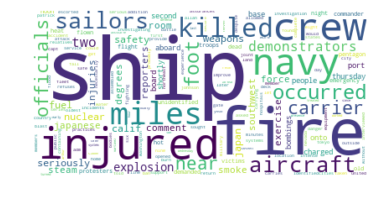

In [14]:
from wordcloud import WordCloud
a = sorted(kl_set[0].items(),key = lambda item:item[1],reverse = True)
print(a)
wordcloud = WordCloud(background_color = "white").generate_from_frequencies(kl_set[0])
%pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

[('complete', 0.12715855), ('presence', 0.12694988), ('northeast', 0.12645562), ('active', 0.12625937), ('degrees', 0.12624964), ('experience', 0.1261026), ('hot', 0.12486189), ('flood', 0.124563254), ('johnson', 0.12431238), ('arthur', 0.124175), ('practices', 0.123987935), ('improve', 0.12370445), ('treated', 0.123670526), ('aboard', 0.12353847), ('smoke', 0.123450674), ('southwest', 0.123427466), ('hospitals', 0.12325514), ('commander', 0.123176284), ('bodies', 0.12305101), ('martinez', 0.12240418), ('demanded', 0.12231401), ('safe', 0.1219575), ('interviewed', 0.12182634), ('assure', 0.12171723), ('battle', 0.121367194), ('intense', 0.12130331), ('injuries', 0.12113945), ('fuel', 0.12105223), ('protesters', 0.12040536), ('onto', 0.12032643), ('location', 0.12028459), ('burn', 0.12012533), ('demonstrators', 0.11985122), ('patrick', 0.119763106), ('capt', 0.1196887), ('carrier', 0.119493924), ('ships', 0.11924384), ('exercise', 0.11901699), ('investigating', 0.11876014), ('explosion'

D:\Anaconda\next_anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


(-0.5, 399.5, 199.5, -0.5)

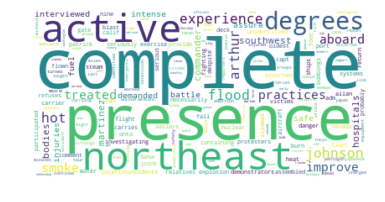

In [13]:
from wordcloud import WordCloud
b = sorted(vim_kl_set[0].items(),key = lambda item:item[1],reverse = True)
print(b)
wordcloud = WordCloud(background_color = "white").generate_from_frequencies(vim_kl_set[0])
%pylab inline
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [15]:
pair

{'ship': 'fleet',
 'crew': 'spacecraft',
 'explosion': 'bomb',
 'foot': 'inches',
 'aircraft': 'aeronautics',
 'miles': 'gallon',
 'injured': 'fatal',
 'navy': 'officer',
 'smoke': 'rain',
 'killed': 'destroying',
 'officials': 'authorities',
 'safety': 'standards',
 'occurred': 'led',
 'weapons': 'firearms',
 'demonstrators': 'picket',
 'sailors': 'pilots',
 'carrier': 'airplane',
 'nuclear': 'radioactive',
 'injuries': 'shoulder',
 'flown': 'helicopters',
 'troops': 'patrols',
 'degrees': 'university',
 'reporters': 'headlines',
 'aboard': 'gunfire',
 'japan': 'dutch',
 'southwest': 'peninsula'}

# rate

In [59]:
def diff(ori_token,vim_token,length):
    tmp = []
    for i in range(len(vim_token)):
        if vim_token[i] != ori_token[i]:
            tmp.append(i)
    return len(tmp)/length
rate = []
for i in range(100):
    if i == 69:
        continue
    print("处理第{}个文本".format(i))
    vim_txt = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_' + str(i) + '.txt'
    new_vim_txt = 'D:\毕设\ML算法实现\主题模型攻击\\nips_model\\nips_UAE\\'+ "G_E_UAE_" + str(topk)+ "_" + str(i) + '.txt'
    ori_bow,ori_index,ori_token,length = word_embedding(dictionary,vim_txt)
    vim_bow,vim_index,vim_token,vlength = word_embedding(dictionary,new_vim_txt)
    cc = diff(ori_token,vim_token,length)
    rate.append(cc)
print(sum(rate)/len(rate))

处理第0个文本
处理第1个文本
处理第2个文本
处理第3个文本
处理第4个文本
处理第5个文本
处理第6个文本
处理第7个文本
处理第8个文本
处理第9个文本
处理第10个文本
处理第11个文本
处理第12个文本
处理第13个文本
处理第14个文本
处理第15个文本
处理第16个文本
处理第17个文本
处理第18个文本
处理第19个文本
处理第20个文本
处理第21个文本
处理第22个文本
处理第23个文本
处理第24个文本
处理第25个文本
处理第26个文本
处理第27个文本
处理第28个文本
处理第29个文本
处理第30个文本
处理第31个文本
处理第32个文本
处理第33个文本
处理第34个文本
处理第35个文本
处理第36个文本
处理第37个文本
处理第38个文本
处理第39个文本
处理第40个文本
处理第41个文本
处理第42个文本
处理第43个文本
处理第44个文本
处理第45个文本
处理第46个文本
处理第47个文本
处理第48个文本
处理第49个文本
处理第50个文本
处理第51个文本
处理第52个文本
处理第53个文本
处理第54个文本
处理第55个文本
处理第56个文本
处理第57个文本
处理第58个文本
处理第59个文本
处理第60个文本
处理第61个文本
处理第62个文本
处理第63个文本
处理第64个文本
处理第65个文本
处理第66个文本
处理第67个文本
处理第68个文本
处理第70个文本
处理第71个文本
处理第72个文本
处理第73个文本
处理第74个文本
处理第75个文本
处理第76个文本
处理第77个文本
处理第78个文本
处理第79个文本
处理第80个文本
处理第81个文本
处理第82个文本
处理第83个文本
处理第84个文本
处理第85个文本
处理第86个文本
处理第87个文本
处理第88个文本
处理第89个文本
处理第90个文本
处理第91个文本
处理第92个文本
处理第93个文本
处理第94个文本
处理第95个文本
处理第96个文本
处理第97个文本
处理第98个文本
处理第99个文本
0.25126159756862015


In [43]:
tmp = []
for i in range(len(vim_token)):
    if vim_token[i] != ori_token[i]:
        tmp.append(i)


In [52]:
'vertices' in vim_token

True

In [48]:
pair

{'predictors': 'behaviors',
 'identification': 'validation',
 'pairs': 'vertices',
 'replacement': 'availability',
 'individual': 'intrinsic',
 'tools': 'items',
 'rejection': 'belief',
 'picture': 'image',
 'solve': 'ambiguities',
 'formulation': 'quantification',
 'solved': 'solving',
 'handwritten': 'documents',
 'gram': 'organism',
 'grant': 'scholarship',
 'coefficients': 'multiplicities',
 'avoiding': 'minimize',
 'nonstandard': 'syntactically',
 'graphical': 'extensible',
 'output': 'capacitance',
 'unit': 'facility',
 'sequentially': 'symmetrically',
 'convex': 'diagonals',
 'regression': 'segmentation',
 'latent': 'symptom',
 'stochastic': 'nonnegative',
 'requiring': 'limiting',
 'filter': 'capacitors',
 'belong': 'differentiates',
 'inclusion': 'presumption',
 'classification': 'taxonomies',
 'database': 'repositories',
 'construct': 'destroy',
 'achieved': 'ranked',
 'sparse': 'paucity',
 'singular': 'prepositions',
 'decompose': 'matrices',
 'scores': 'cues',
 'coupled': '